In [8]:
# Import all packages
import cv2
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.framework import ops

train_graph = tf.Graph()

In [2]:
DATA_FILE = "driving_log.csv"
CHECKPOINT = "./train_model.ckpt"

In [3]:
# Load the driving_log.csv file to look into data
log = pd.read_csv(DATA_FILE)

log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [4]:
images = []
labels = []
alpha = 0.2

In [5]:
# Iterate througth the log file to extract the information
for index, row in log.iterrows():
    
    # Load the center image and append the steering value
    image_file = row['center']
    image = cv2.imread(image_file.strip())
    resized_image = cv2.resize((cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[:, :, 1], (40, 40))
    images.append(resized_image)
    labels.append(row['steering'])
    
    # Load the left image and append the steering value + alpha
    image_file = row['left']
    image = cv2.imread(image_file.strip())
    resized_image = cv2.resize((cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[:, :, 1], (40, 40))
    images.append(resized_image)
    labels.append(row['steering'] + alpha)
    
    # Load the left image and append the steering value - alpha
    image_file = row['right']
    image = cv2.imread(image_file.strip())
    resized_image = cv2.resize((cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[:, :, 1], (40, 40))
    images.append(resized_image)
    labels.append(row['steering'] - alpha)
    
print(str(len(images)) + " images")
print(str(len(labels)) + " labels")

24108 images
24108 labels


In [6]:
# Convert the images and labels into numpy array
images = np.array(images).astype('float32') / 255.0
labels = np.array(labels).astype('float32')

print("Images shape: " + str(images.shape))
print("Labels shape: " + str(labels.shape))

Images shape: (24108, 40, 40)
Labels shape: (24108,)


In [10]:
# Augment the images by mirroring all the images.
images = np.append(images, images[:, :, ::-1], axis=0)
labels = np.append(labels, -labels, axis=0)

print("After augmenting...")
print("Images shape: " + str(images.shape))
print("Labels shape: " + str(labels.shape))

After augmenting...
Images shape: (48216, 40, 40)
Labels shape: (48216,)


In [11]:
# Shuffle the train images and split into trian and test data
images, labels = shuffle(images, labels)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, random_state=0, test_size=0.1)
print("Number of Training examples: " + str(train_images.shape[0]))
print("Number of Testing examples: " + str(test_images.shape[0]))

# Reshape the images along with the number of channels
train_images = train_images.reshape(train_images.shape[0], 40, 40, 1)
test_images = test_images.reshape(test_images.shape[0], 40, 40, 1)
print("train_images shape: " + str(train_images.shape))
print("test_images shape: " + str(test_images.shape))

# Reshape the labels too
train_labels = train_labels.reshape(train_labels.shape[0], 1)
test_labels = test_labels.reshape(test_labels.shape[0], 1)
print("train_labels shape: " + str(train_labels.shape))
print("test_labels shape: " + str(test_labels.shape))

Number of Training examples: 43394
Number of Testing examples: 4822
train_images shape: (43394, 40, 40, 1)
test_images shape: (4822, 40, 40, 1)
train_labels shape: (43394, 1)
test_labels shape: (4822, 1)


In [12]:
m = train_images.shape[0] # Number of training examples
n_H = train_images.shape[1] # Images' height
n_W = train_images.shape[2] # Images' width
n_C = train_images.shape[3] # number of channels
n_cls = train_labels.shape[1] # number of classes

# Create placeholders for the train data and label
with train_graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name = 'input')
    Y = tf.placeholder(tf.float32, [None, n_cls], name = 'output')

In [13]:
# Initialize the weights for the convolution layers
# shape = [filter_size, filter_size, num_input_channels, num_filters]
with train_graph.as_default():
    W1 = tf.get_variable("W1", [3, 3, 1, 32], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [3, 3, 32, 64], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [3, 3, 64, 128], initializer = tf.contrib.layers.xavier_initializer(seed=0))

In [14]:
# Create convolutional neural network
with train_graph.as_default():
    # Layer1 - Convolutional
    conv_layer1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME', name = 'conv1')
    relu_layer1 = tf.nn.relu(conv_layer1, name = 'relu1')
    max_pool_layer1 = tf.nn.max_pool(relu_layer1, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding='VALID', name = 'pool1')

    # Layer2 - Convolutional
    conv_layer2 = tf.nn.conv2d(max_pool_layer1, W2, strides=[1, 1, 1, 1], padding='SAME', name = 'conv2')
    relu_layer2 = tf.nn.relu(conv_layer2, name = 'relu2')
    max_pool_layer2 = tf.nn.max_pool(relu_layer2, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding='VALID', name = 'pool2')
    
    # Layer3 - Convolutional
    conv_layer3 = tf.nn.conv2d(max_pool_layer2, W3, strides=[1, 1, 1, 1], padding='SAME', name = 'conv3')
    relu_layer3 = tf.nn.relu(conv_layer3, name = 'relu3')
    max_pool_layer3 = tf.nn.max_pool(relu_layer3, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding='VALID', name = 'pool3')

    # Layer4 - Fully_Connected (Don't forget to flatten the previous layer and then apply dropout)
    flatten_layer4 = tf.contrib.layers.flatten(max_pool_layer3)
    dropout4 = tf.nn.dropout(flatten_layer4, 0.5, name = 'dropout1')
    fc_layer4 = tf.contrib.layers.fully_connected(dropout4, 128, activation_fn=tf.nn.relu, scope = 'fc1')
    
    # Layer5 - Fully_Connected
    fc_layer5 = tf.contrib.layers.fully_connected(fc_layer4, 64, activation_fn=tf.nn.relu, scope = 'fc2')

    # Layer6 - Fully_Connected
    fc_layer6 = tf.contrib.layers.fully_connected(fc_layer5, n_cls, activation_fn=None, scope = 'fc3')
    print(fc_layer6)

Tensor("fc3/BiasAdd:0", shape=(?, 1), dtype=float32)


In [15]:
# Use mean square error cost function
with train_graph.as_default():
    # Use mean squared error as the cost function
    cost = tf.losses.mean_squared_error(labels = Y, predictions = fc_layer6)

    # Use adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

In [16]:
# Funcion: To pick random minibatches to train the model
def random_mini_batches(train, labels, batch_size, seed):
    # Always change the seed so that we randomize in different order
    np.random.seed(seed)
    # Make sure we shuffle both the train data and the label in the same order
    p = np.random.permutation(len(train))
    train = train[p]
    labels = labels[p]
    train_batches = []
    label_batches = []
    # Dividing the train data into minibatches
    for batch_i in range(0, len(train)//batch_size):
        start_i = batch_i * batch_size
        train_batch = train[start_i:start_i + batch_size]
        label_batch = labels[start_i:start_i + batch_size]
        train_batches.append(train_batch)
        label_batches.append(label_batch)
            
    return train_batches, label_batches 

Epoch 0 completed : Time usage 9 minutes
	- Cost after epoch 0: 0.012387
Epoch 1 completed : Time usage 9 minutes
	- Cost after epoch 1: 0.009203
Epoch 2 completed : Time usage 9 minutes
	- Cost after epoch 2: 0.008529
Epoch 3 completed : Time usage 9 minutes
	- Cost after epoch 3: 0.008020
Epoch 4 completed : Time usage 9 minutes
	- Cost after epoch 4: 0.007548


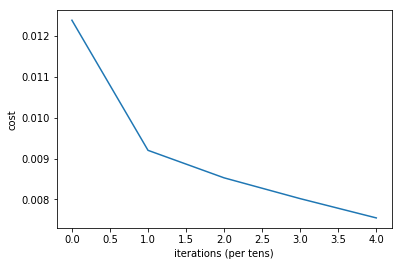

Test MSE: 0.0082


In [18]:
ops.reset_default_graph()
tf.set_random_seed(1)

# Initialize all the hyperparameters
seed = 3
num_epochs = 5
minibatch_size = 64
costs = [] 

# Training the model
with tf.Session(graph=train_graph) as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    # loader = tf.train.import_meta_graph("./" + CHECKPOINT + '.meta')
    # loader.restore(sess, CHECKPOINT)
    
    # Loop over number of epochs
    for epoch in range(num_epochs):
        
        start_time = time.time()
        minibatch_cost = 0
        num_minibatches = int(m / minibatch_size)
        seed = seed + 1
        # Calling the random_mini_batches function to get the batches
        train_batches, label_batches = random_mini_batches(train_images, train_labels, minibatch_size, seed)
        
        # Now train the model for each of that batches and calculate the minibatch cost
        for batch_i in range(num_minibatches):
            
            # Choose the minibatches
            minibatch_X = train_batches[batch_i]
            minibatch_Y = label_batches[batch_i]
            
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
            
            minibatch_cost += temp_cost / num_minibatches
            
        # Print the cost for every epoch
        print("Epoch " + str(epoch) + " completed : Time usage " + str(int((time.time()-start_time)/60)) + " minutes")
        print("\t- Cost after epoch %i: %f" % (epoch, minibatch_cost))
        
        # Don't forget to save the model
        saver = tf.train.Saver() 
        saver.save(sess, CHECKPOINT)
        costs.append(minibatch_cost)
            
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.show()
    
    # Calculate MSE for the testing data
    test_pred = sess.run(fc_layer6, feed_dict={X: test_images})
    test_mse = tf.reduce_mean(tf.square(test_pred - test_labels))
    print("Test MSE: %.4f" % sess.run(test_mse))